In [ ]:
%%capture
!pip install rouge_score
!pip install datasets
!pip install transformers
! pip install dill==0.3.6
import datasets
import transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizerFast, TFEncoderDecoderModel, AdamWeightDecay
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from tensorflow.python.ops.numpy_ops import np_config
from pprint import pprint
""
# enable model saving at eager mode
np_config.enable_numpy_behavior()
print('transformers version:', transformers.__version__)
print('tensorflow version:', tf.__version__)

transformers version: 4.25.1
tensorflow version: 2.9.2


In [ ]:
df_reviews=pd.read_csv("/content/Experiment9.csv")
df_reviews.head()

,Unnamed: 0,paragraphs,summary
0,0,jakarta cnn indonesia dokter ryan thamrin yang...,dokter lula kamal yang merupakan selebriti sek...
1,1,selfie ialah salah satu tema terpanas di kalan...,asus memperkenalkan zenfone generasi keempat d...
2,2,jakarta cnn indonesia dinas pariwisata provins...,dinas pariwisata provinsi bengkulu kembali men...
3,3,merdeka com indonesia corruption watch icw mem...,indonesia corruption watch icw meminta komisi ...
4,4,merdeka com presiden joko widodo jokowi memimp...,jokowi memimpin upacara penurunan bendera usai...


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262 entries, 0 to 14261
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14262 non-null  int64 
 1   paragraphs  14262 non-null  object
 2   summary     14262 non-null  object
dtypes: int64(1), object(2)
memory usage: 334.4+ KB


In [ ]:
import nltk #import library nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize #import word_tokenize for tokenizing text into words 
#word tokenization
def word_tokenization(s):
    tokens = word_tokenize(s)
    return tokens

df_reviews['paragraphs'] = df_reviews['paragraphs'].apply(word_tokenization).apply(str)
pd.DataFrame(df_reviews['paragraphs'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,paragraphs
0,"['jakarta', 'cnn', 'indonesia', 'dokter', 'rya..."
1,"['selfie', 'ialah', 'salah', 'satu', 'tema', '..."
2,"['jakarta', 'cnn', 'indonesia', 'dinas', 'pari..."
3,"['merdeka', 'com', 'indonesia', 'corruption', ..."
4,"['merdeka', 'com', 'presiden', 'joko', 'widodo..."
...,...
14257,"['jakarta', 'cnn', 'indonesia', 'amerika', 'se..."
14258,"['bandung', 'cnn', 'indonesia', 'borneo', 'fc'..."
14259,"['jakarta', 'pos', 'kota', 'a', 'komisi', 'pem..."
14260,"['merdeka', 'com', 'sebuah', 'kabar', 'gembira..."


In [ ]:
df_reviews.to_pickle('df.pkl')

Text(0.5, 1.0, 'Histogram of length of tokenized summary')

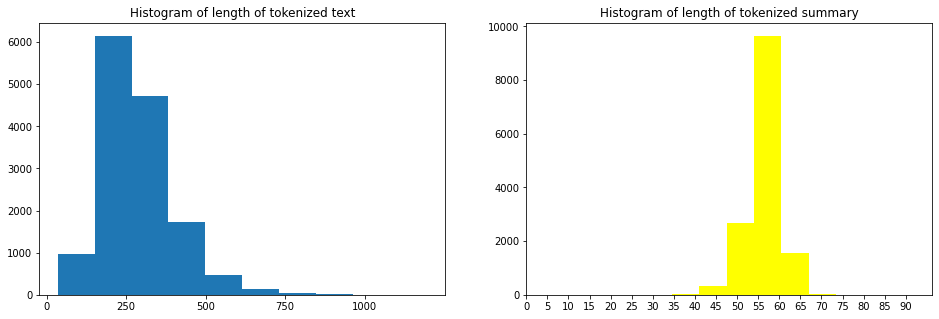

In [ ]:
df_reviews = pd.read_pickle('df.pkl')
df_reviews_sampled = df_reviews.copy()
# sampling n pairs of reviews and summarizies on shuffled dataframe
df_reviews_sampled = df_reviews_sampled.iloc[:40000, :]
df_reviews_sampled['text_len'] = df_reviews_sampled['paragraphs'].apply(lambda x: len(x.split()))
df_reviews_sampled['summary_len'] = df_reviews_sampled['summary'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].hist(df_reviews_sampled['text_len'])
ax[0].set_xticks(np.arange(0, max(df_reviews_sampled['text_len'])+1,250))
ax[0].set_title('Histogram of length of tokenized text')
ax[1].hist(df_reviews_sampled['summary_len'], color='yellow')
ax[1].set_xticks(np.arange(0, max(df_reviews_sampled['summary_len'])+1,5))
ax[1].set_title('Histogram of length of tokenized summary')

In [ ]:
class TrainingConfig:
    from_pt=True 
    val_split = 0.2
    pretrained_checkpoint = 'indolem/indobert-base-uncased'
    encoder_checkpoint = 'indolem/indobert-base-uncased'
    decoder_checkpoint = 'indolem/indobert-base-uncased'
    pad_token_id = 0
    shared_weight = False
    encoder_max_len = 256 
    decoder_max_len = 30 
    nb_epoch = 7 
    learning_rate = 3e-5 
    batch_size = 16
    
    
    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

In [ ]:
class DataLoader:
    def __init__(self, paragraphs, summaries, **kwargs):
        self.paragraphs = paragraphs 
        self.summaries = summaries 
        self.tokenizer = kwargs.get('tokenizer')
        self.val_split = kwargs.get('val_split')
        self.encoder_max_len = kwargs.get('encoder_max_len')
        self.decoder_max_len = kwargs.get('decoder_max_len')
    
    @property
    def sample_size(self):
        assert len(self.paragraphs)==len(self.summaries)
        return len(self.paragraphs)
    
    def split_train_test(self):
        train_idx, val_idx = train_test_split(
            list(range(self.sample_size)), 
            test_size=self.val_split, 
            random_state=98
        )
        return train_idx, val_idx
    
    def convert_text_to_ids(self, input_paragraphs, input_summaries):
        inputs = self.tokenizer(
            list(input_paragraphs), 
            return_tensors='np', 
            padding='max_length', 
            truncation=True, 
            max_length=self.encoder_max_len
        )
        outputs = self.tokenizer(
            list(input_summaries), 
            return_tensors='np', 
            padding='max_length', 
            truncation=True, 
            max_length=self.decoder_max_len
        )
        return inputs, outputs
    
    def list_to_tensor_dataset(self, input_paragraphs, input_summaries):
        inputs, outputs = self.convert_text_to_ids(
            input_paragraphs, 
            input_summaries
        )
        input_ids = tf.data.Dataset.from_tensor_slices(
            inputs['input_ids']
        )
        attention_masks = tf.data.Dataset.from_tensor_slices(
            inputs['attention_mask']
        )
        output_ids = tf.data.Dataset.from_tensor_slices(
            outputs['input_ids']
        )
        output_attention_masks = tf.data.Dataset.from_tensor_slices(
            outputs['attention_mask']
        )                                                
        tf_dataset = tf.data.Dataset.zip(
            ({
                'input_ids': input_ids, 
                'attention_mask': attention_masks,
                'decoder_input_ids': output_ids, 
                 'decoder_attention_mask': output_attention_masks
            }, 
            output_ids)
        )
        return tf_dataset
    
    def __call__(self):
        train_idx, val_idx = self.split_train_test()
        train_paras, val_paras = self.paragraphs[train_idx], self.paragraphs[val_idx]
        train_sums, val_sums = self.summaries[train_idx], self.summaries[val_idx]
        train_dataset = self.list_to_tensor_dataset(train_paras, train_sums)
        val_dataset = self.list_to_tensor_dataset(val_paras, val_sums)
        return train_dataset, val_dataset

In [ ]:
class Seq2SeqLoss(tf.keras.losses.Loss):
    def __init__(self, pad_token_id, name="seq2seq_loss"):
        super().__init__(name=name)
        self.pad_token_id = pad_token_id

    def call(self, y_true, y_pred):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )
        # shift the label and output sequences to match  
        output_logits = y_pred[:,:-1,:]
        input_labels = y_true[:,1:] 
        loss = loss_fn(input_labels, output_logits)
        # calculate loss without the padding tokens in label sequence
        mask = tf.cast((input_labels != self.pad_token_id), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, metric):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.metric = metric
        # loss tracker will capture the mean of loss till now
        self.loss_tracker = tf.keras.metrics.Mean(name='mean_loss')
    
    # Training Step
    @tf.function 
    def train_step(self, inputs):
        input_seqs, input_labels = inputs
        with tf.GradientTape() as tape: 
            outputs = self.model(
                input_seqs['input_ids'],
                input_seqs['attention_mask'],
                input_seqs['decoder_input_ids'],
                input_seqs['decoder_attention_mask'],
                training = True
            )
            logits = outputs.logits
            loss = self.loss_fn(input_labels, logits)
        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.model.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
#         self.metric.update_state(y, predictions)
        return loss
        
    # Validation Step
    @tf.function  
    def val_step(self, inputs):
        input_seqs, input_labels = inputs
        outputs = self.model(                
                input_seqs['input_ids'],
                input_seqs['attention_mask'],
                input_seqs['decoder_input_ids'],
                input_seqs['decoder_attention_mask'],
                training = False
        )
        logits = outputs.logits
        loss = self.loss_fn(input_labels, logits)
        self.loss_tracker.update_state(loss)
#         self.metric.update_state(y,predictions)
        return loss

In [ ]:
def batched_generate_summary(model, tokenizer, batched_input):
    input_seqs, input_labels = batched_input
    outputs = model.generate(
        input_ids=input_seqs['input_ids'], 
        attention_mask=input_seqs['attention_mask']
    )
    output_strs = tokenizer.batch_decode(
        outputs, 
        skip_special_tokens=True
    )
    output_gold = tokenizer.batch_decode(
        input_seqs['decoder_input_ids'], 
        skip_special_tokens=True
    )
    input_strs = tokenizer.batch_decode(
        input_seqs['input_ids'], 
        skip_special_tokens=True
    )
    return output_strs, output_gold, input_strs

In [ ]:
reviews = df_reviews_sampled['paragraphs'].values
summaries = df_reviews_sampled['summary'].values

training_config = TrainingConfig(nb_epoch=7)
tokenizer = BertTokenizerFast.from_pretrained(training_config.encoder_checkpoint)

dataloader_args = {
    'tokenizer': tokenizer,
    'val_split': training_config.val_split,
    'encoder_max_len': training_config.encoder_max_len,
    'decoder_max_len': training_config.decoder_max_len
}
dataloader = DataLoader(reviews, summaries, **dataloader_args)
train_dataset, val_dataset = dataloader()
train_dataset = (train_dataset
                 .shuffle(int(dataloader.sample_size*(1-training_config.val_split)))
                 .batch(training_config.batch_size))
val_dataset = val_dataset.batch(training_config.batch_size)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [ ]:
model = transformers.EncoderDecoderModel.from_encoder_decoder_pretrained(
    training_config.encoder_checkpoint, 
    training_config.decoder_checkpoint,
    tie_encoder_decoder=training_config.shared_weight,from_pt=True)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
model.save_pretrained('indolem/indobert-base-uncased')
model = TFEncoderDecoderModel.from_pretrained('/content/indolem/indobert-base-uncased',from_pt=True)

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id # 101
model.config.eos_token_id = tokenizer.sep_token_id # 102 
model.config.pad_token_id = tokenizer.pad_token_id # 0
model.config.vocab_size = model.config.encoder.vocab_size 

In [ ]:
model.config.max_length = 30
model.config.min_length = 3
model.config.no_repeat_ngram_size = 2
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
#rouge = datasets.load_metric('rouge')
tf.keras.backend.clear_session()
trainer = Trainer(model=model,
                  loss_fn=Seq2SeqLoss(training_config.pad_token_id),
                  optimizer=AdamWeightDecay(
                      learning_rate=training_config.learning_rate, 
                      weight_decay_rate=0.005),
                  metric=None)

In [ ]:
import datasets
rouge = datasets.load_metric("rouge")
for epoch in range(training_config.nb_epoch):
    print(f'\nEpoch {epoch+1}\n')
    print('Training....')
    for step,batched_input in enumerate(tqdm(train_dataset)):
        loss = trainer.train_step(batched_input)
        till_now_loss = trainer.loss_tracker.result()
        if step%200 == 0:
            print(f'Training loss for one batch at step {step}: {round(till_now_loss,3)}') 
    trainer.loss_tracker.reset_states()
    print('Validating....')
    val_measures = {'rouge precision':0, 'rouge recall':0, 'rouge f1': 0}
    for step, batched_input in enumerate(tqdm(val_dataset)):
        val_loss = trainer.val_step(batched_input)
    till_now_val_loss = trainer.loss_tracker.result()
    print(f'Validation loss: {round(till_now_val_loss,3)}')
    model.save_pretrained(
        f'bert2bert-Checkpoint-epoch{epoch+1}-loss{round(till_now_val_loss,3)}'
    )
    trainer.loss_tracker.reset_states()

<ipython-input-19-adafa7a0519c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")



Epoch 1

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 11.883000373840332
Training loss for one batch at step 200: 7.554999828338623
Training loss for one batch at step 400: 6.690000057220459
Training loss for one batch at step 600: 6.170000076293945


Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 4.4029998779296875

Epoch 2

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 4.614999771118164
Training loss for one batch at step 200: 4.359000205993652
Training loss for one batch at step 400: 4.2789998054504395
Training loss for one batch at step 600: 4.203000068664551
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 3.8399999141693115

Epoch 3

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 3.799999952316284
Training loss for one batch at step 200: 3.568000078201294
Training loss for one batch at step 400: 3.5399999618530273
Training loss for one batch at step 600: 3.513000011444092
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 3.6050000190734863

Epoch 4

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 2.869999885559082
Training loss for one batch at step 200: 3.0490000247955322
Training loss for one batch at step 400: 3.0169999599456787
Training loss for one batch at step 600: 3.010999917984009
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 3.4549999237060547

Epoch 5

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 2.6630001068115234
Training loss for one batch at step 200: 2.5769999027252197
Training loss for one batch at step 400: 2.572000026702881
Training loss for one batch at step 600: 2.566999912261963
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 3.249000072479248

Epoch 6

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 2.1470000743865967
Training loss for one batch at step 200: 2.13100004196167
Training loss for one batch at step 400: 2.13100004196167
Training loss for one batch at step 600: 2.13100004196167
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 3.1029999256134033

Epoch 7

Training....


  0%|          | 0/714 [00:00<?, ?it/s]

Training loss for one batch at step 0: 1.6390000581741333
Training loss for one batch at step 200: 1.7430000305175781
Training loss for one batch at step 400: 1.7510000467300415
Training loss for one batch at step 600: 1.7619999647140503
Validating....


  0%|          | 0/179 [00:00<?, ?it/s]

Validation loss: 2.9790000915527344


In [ ]:
# from transformers import 
import datasets
rouge = datasets.load_metric("rouge")
trained_bert2bert = TFEncoderDecoderModel.from_pretrained("/content/bert2bert-Checkpoint-epoch7-loss2.9790000915527344")

# val0 = list(val_dataset.as_numpy_iterator())[0]
for step, batched_input in enumerate(tqdm(val_dataset)):
    pred_str, gold_str, input_strs = batched_generate_summary(
        trained_bert2bert, 
        tokenizer, 
        batched_input
    )
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=gold_str,
        rouge_types=["rouge1","rouge2","rougeL"]
    )
    print('Rouge report: ')
    print("ROUGE 1 SCORE: ",rouge_output['rouge1'].mid)
    print("ROUGE 2 SCORE: ",rouge_output['rouge2'].mid)
    print("ROUGE F SCORE: ",rouge_output['rougeL'].mid)
    for p_str,g_str,in_str in zip(pred_str, gold_str, input_strs):
        print('='*100)
        print('Review: ' + in_str)
        print('Summary: ' + g_str)
        print('Generated: ' + p_str)
    
    break

  0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:1800: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 30 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Rouge report: 
ROUGE 1 SCORE:  Score(precision=0.45356285170143873, recall=0.4880458533383305, fmeasure=0.4689294446200998)
ROUGE 2 SCORE:  Score(precision=0.23114012547436458, recall=0.24686477491647685, fmeasure=0.23795811309214693)
ROUGE F SCORE:  Score(precision=0.39412823941356556, recall=0.4221578572790673, fmeasure=0.40627471437762624)
Review: ['jakarta ','cnn ','indonesia ','direktur ','utama ','pt ','transjakarta ','budi ','kaliwono ','meminta ','maaf ','kepada ','pelanggan ','terkait ','gangguan ','pelayanan ','transjakarta ','di ','beberapa ','koridor ','yang ','disebabkan ','aksi ','karyawan ','menuntut ','kenaikan ','gaji ','dan ','penetapan ','status ','karyawan ','tetap ','senin ','kami ','merasa ','bersalah ','pada ','pelanggan ','karena ','adanya ','gangguan ','ini ','kata ','budi ','saat ','ditemui ','di ','kantornya ','yang ','berada ','di ','kawasan ','cawang ','jakarta ','timur ','budi ','mengatakan ','tidak ','beroperasinya ','ratusan ','armada ','transjakarta ','

In [ ]:
df_reviews_test = pd.read_csv("/content/Test9.csv")
test_reviews = df_reviews_test['paragraphs'].values
test_sums = df_reviews_test['summary'].values

test_dataloader = DataLoader(test_reviews, test_sums, **dataloader_args)
test_dataset = test_dataloader.list_to_tensor_dataset(test_reviews, test_sums)
test_dataset = test_dataset.batch(training_config.batch_size)
pred_strs = []
gold_strs = []

for batched_input in tqdm(test_dataset):
    pred_str, gold_str, _ = batched_generate_summary(
        trained_bert2bert, 
        tokenizer, 
        batched_input
    )
    pred_strs.extend(pred_str)
    gold_strs.extend(gold_str)
    
rouge_output = rouge.compute(
    predictions=pred_strs,
    references=gold_strs,
    rouge_types=["rouge1","rouge2","rougeL"]
)

  0%|          | 0/236 [00:00<?, ?it/s]

In [ ]:
print('Rouge report: ')
print("ROUGE 1 SCORE: ",rouge_output['rouge1'].mid)
print("ROUGE 2 SCORE: ",rouge_output['rouge2'].mid)
print("ROUGE F SCORE: ",rouge_output['rougeL'].mid)

Rouge report: 
ROUGE 1 SCORE:  Score(precision=0.2227554445178579, recall=0.21595992875931008, fmeasure=0.21867345366855317)
ROUGE 2 SCORE:  Score(precision=0.05680066133759504, recall=0.054894179176467425, fmeasure=0.05566665226205188)
ROUGE F SCORE:  Score(precision=0.17756447931867533, recall=0.17203228028464004, fmeasure=0.17421648448214686)


In [ ]:
rouge_output

{'rouge1': AggregateScore(low=Score(precision=0.2196984311709091, recall=0.21309230291742925, fmeasure=0.21572721606089157), mid=Score(precision=0.2227554445178579, recall=0.21595992875931008, fmeasure=0.21867345366855317), high=Score(precision=0.22622736793402026, recall=0.2193677127284444, fmeasure=0.22214028378778664)),
 'rouge2': AggregateScore(low=Score(precision=0.054563314747654426, recall=0.052801198602724406, fmeasure=0.05353323017593712), mid=Score(precision=0.05680066133759504, recall=0.054894179176467425, fmeasure=0.05566665226205188), high=Score(precision=0.058969155103084696, recall=0.05695194107149069, fmeasure=0.05775942026274655)),
 'rougeL': AggregateScore(low=Score(precision=0.17487134774468444, recall=0.16954977584574318, fmeasure=0.17165676147927295), mid=Score(precision=0.17756447931867533, recall=0.17203228028464004, fmeasure=0.17421648448214686), high=Score(precision=0.1799422546459486, recall=0.17444599596062246, fmeasure=0.17654390551541896))}

In [ ]:
!cp -r /content/bert2bert-Checkpoint-epoch7-loss2.9790000915527344 "/content/drive/MyDrive"